#  Movie Sentiment Classifier using BiLSTM Word2Vec   

Bidirectional long-short term memory(bi-lstm) is the process of making any neural network o have the sequence information in both directions backwards (future to past) or forward(past to future). 

Word2Vec is a shallow, two-layer neural networks which is trained to reconstruct linguistic contexts of words. 
It takes as its input a large corpus of words and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space.
Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.
Word2Vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text.

CBOW (continuous bag of words) and the skip-gram model are the two main architectures associated with Word2vec. 

We will grab the data from the movie review dataset.

In [1]:
#import the libraies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import codecs
from tqdm import tqdm
import time
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from gensim.models import Word2Vec as w2v

from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, MaxPooling1D, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
#read the dataset
df=pd.read_csv('https://raw.githubusercontent.com/arditoibryan/Projects/master/20200602_Twitter_Sentiment_Analysis/movie_review.csv')

In [3]:
df.head()

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


In [4]:
df.shape

(64720, 6)

In [5]:
df['tag'].value_counts()

pos    32937
neg    31783
Name: tag, dtype: int64

Tags are the target in our dataset where 'pos' stands for positive and 'neg' is negative. We drop the columns which are not required.

In [6]:
df = df.drop(['fold_id', 'cv_tag', 'html_id', 'sent_id'], axis=1)

In [7]:
df.head()

,text,tag
0,films adapted from comic books have had plenty...,pos
1,"for starters , it was created by alan moore ( ...",pos
2,to say moore and campbell thoroughly researche...,pos
3,"the book ( or "" graphic novel , "" if you will ...",pos
4,"in other words , don't dismiss this film becau...",pos


In [8]:
df.columns = ['tweets', 'sentiment']

In [9]:
df.head()

,tweets,sentiment
0,films adapted from comic books have had plenty...,pos
1,"for starters , it was created by alan moore ( ...",pos
2,to say moore and campbell thoroughly researche...,pos
3,"the book ( or "" graphic novel , "" if you will ...",pos
4,"in other words , don't dismiss this film becau...",pos


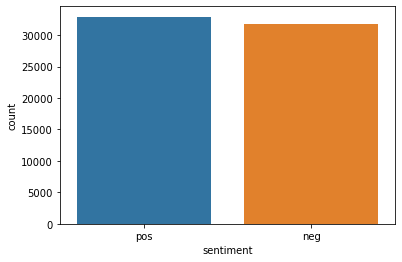

In [10]:
# Check whether the datset us balanced
sns.countplot(x="sentiment", data=df);

In [11]:
# change sentiment value to either 0 or 1
df['sentiment'] = [1 if s=='pos' else 0 for s in df['sentiment']]

In [12]:
df.head()

,tweets,sentiment
0,films adapted from comic books have had plenty...,1
1,"for starters , it was created by alan moore ( ...",1
2,to say moore and campbell thoroughly researche...,1
3,"the book ( or "" graphic novel , "" if you will ...",1
4,"in other words , don't dismiss this film becau...",1


In [13]:
df_preprocess = df.copy()

In [14]:
stopword = stopwords.words('english')

df['stopwords'] = df['tweets'].apply(lambda x: len([x for x in x.split() if x in stopword]))
df.head()

,tweets,sentiment,stopwords
0,films adapted from comic books have had plenty...,1,13
1,"for starters , it was created by alan moore ( ...",1,14
2,to say moore and campbell thoroughly researche...,1,9
3,"the book ( or "" graphic novel , "" if you will ...",1,12
4,"in other words , don't dismiss this film becau...",1,7


In [15]:
df['char_count'] = df['tweets'].str.len()
df.head()

,tweets,sentiment,stopwords,char_count
0,films adapted from comic books have had plenty...,1,13,265
1,"for starters , it was created by alan moore ( ...",1,14,172
2,to say moore and campbell thoroughly researche...,1,9,150
3,"the book ( or "" graphic novel , "" if you will ...",1,12,138
4,"in other words , don't dismiss this film becau...",1,7,64


In [16]:
df['word_count'] = df['tweets'].apply(lambda x: len(str(x).split(" ")))
df.head()

,tweets,sentiment,stopwords,char_count,word_count
0,films adapted from comic books have had plenty...,1,13,265,52
1,"for starters , it was created by alan moore ( ...",1,14,172,36
2,to say moore and campbell thoroughly researche...,1,9,150,27
3,"the book ( or "" graphic novel , "" if you will ...",1,12,138,30
4,"in other words , don't dismiss this film becau...",1,7,64,13


In [17]:
dg= df[['stopwords', 'char_count', 'word_count']]

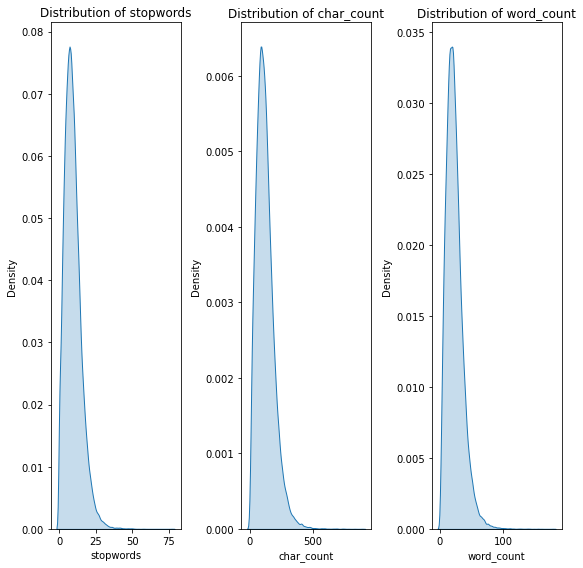

In [18]:
#  Categorical Data
a = 1  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(8,8))

for i in dg:
    plt.subplot(a, b, c)
    plt.title('Distribution of {}'.format(i))
    plt.xlabel(i)
    sns.kdeplot(dg[i], fill=True)
    c = c + 1

plt.tight_layout()
plt.show()

In [19]:
tweets = df_preprocess.tweets
tweets.head()

0    films adapted from comic books have had plenty...
1    for starters , it was created by alan moore ( ...
2    to say moore and campbell thoroughly researche...
3    the book ( or " graphic novel , " if you will ...
4    in other words , don't dismiss this film becau...
Name: tweets, dtype: object

In [20]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [21]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [22]:
df_preprocess.tweets = df_preprocess.tweets.apply(lambda x: preprocess(x))

In [23]:
df_preprocess= df_preprocess[['tweets', 'sentiment']]

In [24]:
df_preprocess.head()

,tweets,sentiment
0,films adapted comic books plenty success wheth...,1
1,starters created alan moore eddie campbell bro...,1
2,say moore campbell thoroughly researched subje...,1
3,book graphic novel 500 pages long includes nea...,1
4,words dismiss film source,1


In [25]:
df_preprocess['sentiment'].value_counts()

1    32937
0    31783
Name: sentiment, dtype: int64

The dataset is balanced

In [26]:
df_preprocess= df_preprocess.rename(columns={'tweets': 'tweet', 'sentiment': 'sentiment'})
df_preprocess.head()

,tweet,sentiment
0,films adapted comic books plenty success wheth...,1
1,starters created alan moore eddie campbell bro...,1
2,say moore campbell thoroughly researched subje...,1
3,book graphic novel 500 pages long includes nea...,1
4,words dismiss film source,1


In [27]:
df_preprocess.shape

(64720, 2)

**Words in the positive and negive corpus**

In [28]:
neg_corpus = []
for msg in df_preprocess[df_preprocess['sentiment'] == 0]['tweet'].tolist():
    for word in msg.split():
        neg_corpus.append(word)

In [29]:
pos_corpus = []
for msg in df_preprocess[df_preprocess['sentiment'] == 1]['tweet'].tolist():
    for word in msg.split():
        pos_corpus.append(word)

In [30]:
len(pos_corpus), len(neg_corpus)

(375079, 333438)

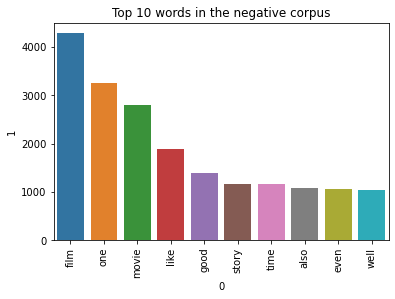

In [31]:
# Top 10 words in the negative corpus
from collections import Counter
sns.barplot(x=pd.DataFrame(Counter(pos_corpus).most_common(10))[0], y=pd.DataFrame(Counter(neg_corpus).most_common(10))[1])
plt.xticks(rotation='vertical')
plt.title('Top 10 words in the negative corpus')
plt.show()

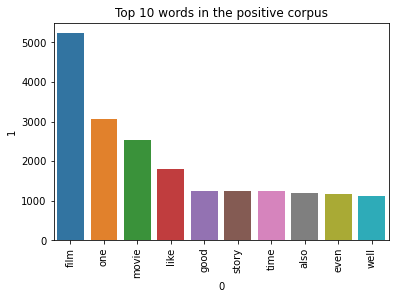

In [32]:
sns.barplot(x=pd.DataFrame(Counter(pos_corpus).most_common(10))[0], y=pd.DataFrame(Counter(pos_corpus).most_common(10))[1])
plt.xticks(rotation='vertical')
plt.title('Top 10 words in the positive corpus')
plt.show()

**keras.preprocessing.text.Tokenizer is a very useful tokenizer for text processing in deep learning**

Tokenizer assumes that the word tokens of the input texts have been delimited by whitespaces.
Tokenizer provides the following functions:

* It will first create a dictionary for the entire corpus (a mapping of each word token and its unique integer index index) (Tokenizer.fit_on_text())

* It can then use the corpus dictionary to convert words in each corpus text into integer sequences (Tokenizer.texts_to_sequences())

* The dictionary is in Tokenizer.word_index


Notes on Tokenizer:
By default, the token index 0 is reserved for padding token.
If oov_token is specified, it is default to index 1. (Default: oov_token=False)
Specify num_words=N for Tokenizer to include only top N words in converting texts to sequences.
Tokenizer will automatically remove punctuations.
Tokenizer use the whitespace as word-token delimiter.
If every character is treated as a token, specify char_level=True.

In [33]:
# Utilize the keras tokenizer
tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(df_preprocess.tweet)

print("The document count", tokenizer.document_count)

The document count 64720


In [34]:
word_index = tokenizer.word_index
word_index

{'film': 1,
 'one': 2,
 'movie': 3,
 'like': 4,
 'even': 5,
 'good': 6,
 'time': 7,
 'story': 8,
 'would': 9,
 'much': 10,
 'character': 11,
 'also': 12,
 'get': 13,
 'two': 14,
 'well': 15,
 'characters': 16,
 'first': 17,
 'see': 18,
 'way': 19,
 'make': 20,
 'life': 21,
 'really': 22,
 'films': 23,
 'plot': 24,
 'little': 25,
 'people': 26,
 'could': 27,
 'man': 28,
 'scene': 29,
 'bad': 30,
 'never': 31,
 'best': 32,
 'new': 33,
 'scenes': 34,
 'many': 35,
 'director': 36,
 'know': 37,
 'movies': 38,
 'action': 39,
 'great': 40,
 'another': 41,
 'love': 42,
 'go': 43,
 'made': 44,
 'us': 45,
 'big': 46,
 'end': 47,
 'something': 48,
 'back': 49,
 'still': 50,
 'world': 51,
 'seems': 52,
 'work': 53,
 'makes': 54,
 'however': 55,
 'every': 56,
 'though': 57,
 'better': 58,
 'real': 59,
 'audience': 60,
 'enough': 61,
 'seen': 62,
 'take': 63,
 'around': 64,
 'going': 65,
 'performance': 66,
 'year': 67,
 'role': 68,
 'old': 69,
 'gets': 70,
 'may': 71,
 'things': 72,
 'last': 73,
 '

In [35]:
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocabulary_size)

Vocabulary Size : 39245


### Create a Word2Vec Embedding

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_preprocess['tweet'], 
                                                    df_preprocess['sentiment'], test_size=0.25, 
                                                    random_state=42)

In [37]:
EMBEDDING_DIM = 300

# Creating Word2Vec train dataset
train_data = [x.split() for x in X_train]

Word2Vec creates and trains the word embeddings using the data passed.

Training Parameters

size: The number of dimensions (N) that the Word2Vec maps the words onto. Bigger size values require more training data, but can lead to better (more accurate) models.

workers: Specifies the number of worker threads for training parallelization, to speed up training.

min_count: min_count is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them.

In [38]:
# Defining the model and train
word2vec_model = w2v(train_data, vector_size=EMBEDDING_DIM, workers=8,min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 12516


In [39]:
# Define the model input length
max_sequence_length = 20

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_sequence_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=max_sequence_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (48540, 20)
X_test.shape : (16180, 20)


**Create Embedding Matrix**

Embedding Matrix is a maxtrix of all words and their corresponding embeddings. We use embedding matrix in an Embedding layer in our model to embedded a token into it's vector representation, that contains information regarding that token or word.

We get the embedding vocabulary from the tokenizer and the corresponding vectors from the Embedding Model, which in this case is the Word2Vec model.

Shape of Embedding matrix is usually the Vocab Length * Embedding Dimension.

In [40]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (39245, 300)


In [41]:
encoded_text=tokenizer.texts_to_sequences(df_preprocess.tweet)

In [42]:
max_sequence_length = 60
X=pad_sequences(encoded_text, maxlen=max_sequence_length, padding='post')
y=df_preprocess['sentiment']

In [43]:
batch_size = 32
epoch = 15

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 48540
Test Data size 16180


In [45]:
embedding_matrix.shape

(39245, 300)

In [46]:
embedding_layer = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_sequence_length,
                                          trainable=False)

We also utilize early stopping.

In [47]:
es=EarlyStopping(monitor='val_loss', min_delta=0, mode='min', verbose=1, patience=10)

reduce_lr = ReduceLROnPlateau(factor=0.1, min_delta=0, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

### Create bidirectional LSTM model using Word2Vec

For creating the model, we use

- Embedding Layer - Generates Embedding Vector for each input sequence.

- LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which further along the text carry contextual meaning rather than just neighbouring words as in case of RNN. Unlike standard LSTM in the bi-directional LSTM the input flows in both directions and is capable of utilizing information from both sides.

- Dense - Fully Connected Layers for classification

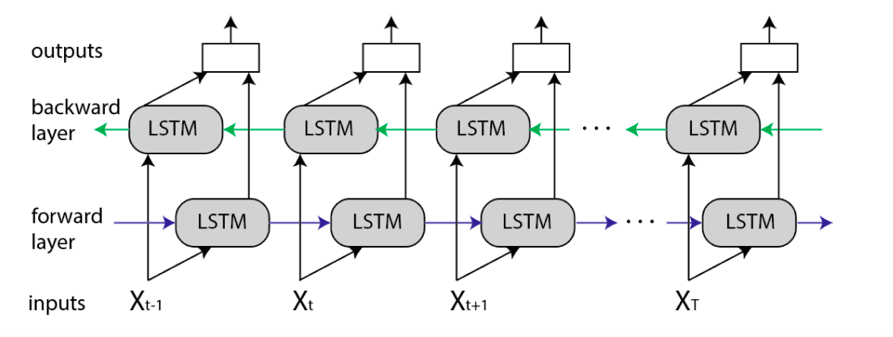

In [48]:
model=Sequential()

model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

2022-11-13 19:41:58.280455: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy',metrics=['accuracy'])

#### Plot the model

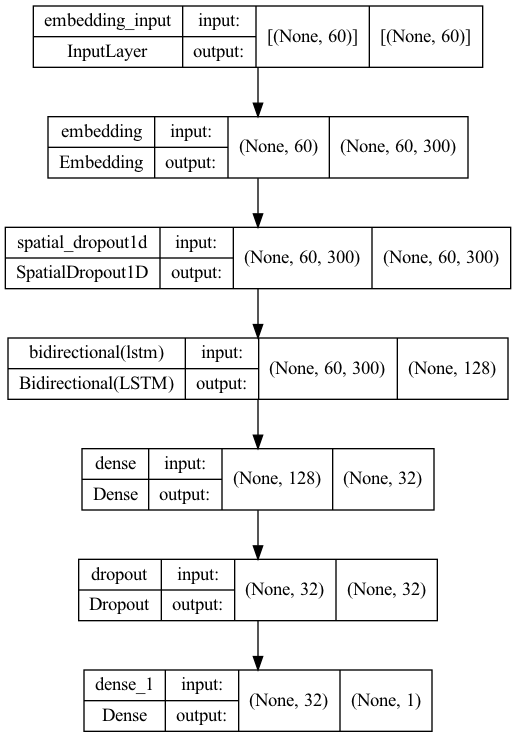

In [50]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [51]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch,
                    validation_data=(X_test, y_test), callbacks= [es, reduce_lr])

Epoch 1/15
1517/1517 [==============================] - 428s 277ms/step - loss: 0.6923 - accuracy: 0.5156 - val_loss: 0.6904 - val_accuracy: 0.5190 - lr: 0.0010
Epoch 2/15
1517/1517 [==============================] - 397s 262ms/step - loss: 0.6910 - accuracy: 0.5279 - val_loss: 0.6894 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 3/15
1517/1517 [==============================] - 373s 246ms/step - loss: 0.6896 - accuracy: 0.5304 - val_loss: 0.6878 - val_accuracy: 0.5386 - lr: 0.0010
Epoch 4/15
1517/1517 [==============================] - 317s 209ms/step - loss: 0.6882 - accuracy: 0.5361 - val_loss: 0.6871 - val_accuracy: 0.5402 - lr: 0.0010
Epoch 5/15
1517/1517 [==============================] - 377s 249ms/step - loss: 0.6874 - accuracy: 0.5367 - val_loss: 0.6863 - val_accuracy: 0.5450 - lr: 0.0010
Epoch 6/15
1517/1517 [==============================] - 355s 234ms/step - loss: 0.6870 - accuracy: 0.5366 - val_loss: 0.6862 - val_accuracy: 0.5403 - lr: 0.0010
Epoch 7/15
1517/1517 [============

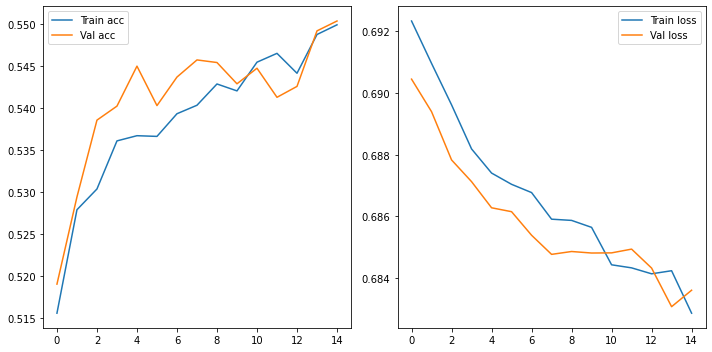

In [52]:
#Plot the learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

506/506 [==============================] - 30s 58ms/step - loss: 0.6836 - accuracy: 0.5504
Accuracy: 55.04%


In [54]:
# Predicting on the Test dataset.
y_pred = model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>0.5, 1, 0)

# Printing out the Evaluation metrics. 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_pred,y_test)
print(cm)

# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

[[4176 3465]
 [3810 4729]]
              precision    recall  f1-score   support

           0       0.55      0.52      0.53      7986
           1       0.55      0.58      0.57      8194

    accuracy                           0.55     16180
   macro avg       0.55      0.55      0.55     16180
weighted avg       0.55      0.55      0.55     16180



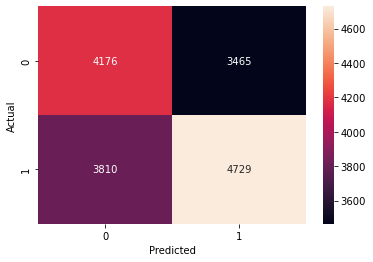

In [55]:
import matplotlib.pyplot as plt

# Plot the confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [56]:
model.save("modelw2v.h5")
print("Saved model to disk")

Saved model to disk


**Predict using the model**

In [57]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"

In [58]:
def decode_sentiment(score):
    return NEGATIVE if score < 0.5 else POSITIVE

In [59]:
def predict(text):
    print(text)
    start_at = time.time()
    # Tokenize text
    X_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_sequence_length)
    # Predict
    score = model.predict([X_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [60]:
predict("The movie was aweful")

The movie was aweful


{'label': 'NEGATIVE',
 'score': 0.4887843728065491,
 'elapsed_time': 1.2178261280059814}

In [61]:
predict("The film was creative and surprising")

The film was creative and surprising


{'label': 'NEGATIVE',
 'score': 0.48867836594581604,
 'elapsed_time': 0.0811612606048584}